In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import os
import numpy as np
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, SimpleRNN, GRU, Dense

In [3]:
# Read in the independent and target variable datasets

stock = 'AAPL'

X_5D = pd.read_parquet(stock + '_X_5D.gzip')
y_1D = pd.read_parquet(stock + '_y_1D.gzip')

In [6]:
# Split the 5D/1D dataset into training, validation and test datasets

window_size = 5
num_features = 20

scaler_y = StandardScaler()

q_80 = int(len(X_5D) * .8)
q_90 = int(len(X_5D) * .9)

X_5D_train, y_1D_train = X_5D[:q_80].to_numpy(), y_1D[:q_80].to_numpy()
X_5D_val, y_1D_val = X_5D[q_80:q_90].to_numpy(), y_1D[q_80:q_90].to_numpy()
X_5D_test, y_1D_test = X_5D[q_90:].to_numpy(), y_1D[q_90:].to_numpy()

X_5D_train = X_5D_train.reshape((-1, window_size, num_features))
X_5D_val = X_5D_val.reshape((-1, window_size, num_features))
X_5D_test = X_5D_test.reshape((-1, window_size, num_features))

y_1D_train_scaled = scaler_y.fit_transform(y_1D_train.reshape(-1, 1))
y_1D_val_scaled = scaler_y.transform(y_1D_val.reshape(-1, 1))

In [ ]:
# Fit an LSTM model to the 5D/1D dataset

model = Sequential([
    LSTM(128, 
         input_shape=(window_size, num_features), 
         dropout=0.2,               # dropout on input (per time step)
         recurrent_dropout=0.2),    # dropout on hidden state (across time)
    Dense(64, activation='relu', kernel_regularizer=regularizers.l1(0.001)),
    Dense(32, activation='relu', kernel_regularizer=regularizers.l1(0.001)),
    Dense(16, activation='relu', kernel_regularizer=regularizers.l1(0.001)),
    Dense(8, activation='relu', kernel_regularizer=regularizers.l1(0.001)),
    Dense(1)
])

early_stop = EarlyStopping(
    monitor='val_loss',        # or 'val_mean_absolute_error', etc.
    patience=5,                # wait 5 epochs for improvement
    restore_best_weights=True  # roll back to best weights
)

model.compile(loss='mean_absolute_error', 
              optimizer=Adam(learning_rate=0.001))

model.fit(X_5D_train, y_1D_train_scaled, validation_data=(X_5D_val, y_1D_val_scaled), epochs=100, callbacks=[early_stop])

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 1.4491 - val_loss: 0.4851
Epoch 2/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.7424 - val_loss: 0.4077
Epoch 3/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.6933 - val_loss: 0.3995
Epoch 4/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.6790 - val_loss: 0.3982
Epoch 5/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.6910 - val_loss: 0.3979
Epoch 6/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.6737 - val_loss: 0.3977
Epoch 7/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.6954 - val_loss: 0.3976
Epoch 8/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.6958 - val_loss: 0.3976
Epoch 9/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.6786 - val_loss: 0.3977
Epoch 10/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.6798 - val_loss: 0.3977
Epoch 11/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.6887 - val_loss: 0.3976
Epoch 12/100
209/209 ━━━━━━━━━

209/209 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


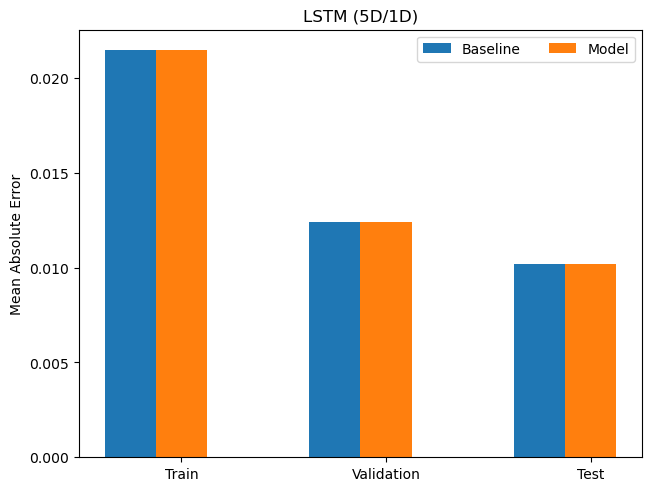

In [16]:
y_1D_train_pred_scaled = model.predict(X_5D_train)
y_1D_train_pred = scaler_y.inverse_transform(y_1D_train_pred_scaled)
train_errors = np.abs(y_1D_train_pred - y_1D_train)
train_baseline_errors = np.abs(y_1D_train)
avg_train_errors = train_errors.mean(axis=0)[0]
avg_train_baseline_errors = train_baseline_errors.mean(axis=0)[0]

y_1D_val_pred_scaled = model.predict(X_5D_val)
y_1D_val_pred = scaler_y.inverse_transform(y_1D_val_pred_scaled)
val_errors = np.abs(y_1D_val_pred - y_1D_val)
val_baseline_errors = np.abs(y_1D_val)
avg_val_errors = val_errors.mean(axis=0)[0]
avg_val_baseline_errors = val_baseline_errors.mean(axis=0)[0]

y_1D_test_pred_scaled = model.predict(X_5D_test)
y_1D_test_pred = scaler_y.inverse_transform(y_1D_test_pred_scaled)
test_errors = np.abs(y_1D_test_pred - y_1D_test)
test_baseline_errors = np.abs(y_1D_test)
avg_test_errors = test_errors.mean(axis=0)[0]
avg_test_baseline_errors = test_baseline_errors.mean(axis=0)[0]

dataset = ('Train', 'Validation', 'Test')
avg_errors = {
    'Baseline': (avg_train_baseline_errors, avg_val_baseline_errors, avg_test_baseline_errors),
    'Model': (avg_train_errors, avg_val_errors, avg_test_errors)
}

x = np.arange(len(dataset))
width = 0.25
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in avg_errors.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    multiplier += 1

ax.set_ylabel('Mean Absolute Error')
ax.set_title('LSTM (5D/1D)')
ax.legend(loc='upper right', ncols=2)
ax.set_xticks(x + width, dataset)

plt.show()

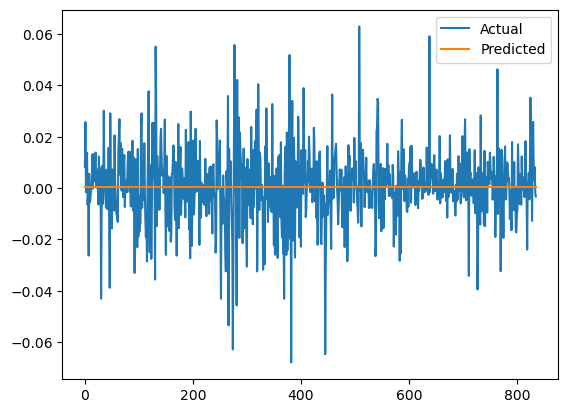

In [17]:
plt.plot(y_1D_test, label='Actual')
plt.plot(y_1D_test_pred, label='Predicted')
plt.legend()
plt.show()